In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from sklearn.metrics import confusion_matrix, classification_report
pd.set_option('display.max_columns', None)
import plotly.express as px
import pathlib
import PIL
import random
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Exploratory Data Analysis

In [ ]:
# Class Labels
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

In [ ]:
meta_df = pd.read_csv('/content/drive/My Drive/Codebasics/GTSCDS/Meta.csv')

In [ ]:
meta_df.sample(3)

,Path,ClassId,ShapeId,ColorId,SignId
18,Meta/24.png,24,0,0,1.5.2
2,Meta/1.png,1,1,0,3.29
17,Meta/23.png,23,0,0,1.13


In [ ]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Path     43 non-null     object
 1   ClassId  43 non-null     int64 
 2   ShapeId  43 non-null     int64 
 3   ColorId  43 non-null     int64 
 4   SignId   42 non-null     object
dtypes: int64(3), object(2)
memory usage: 1.8+ KB


In [ ]:
test_df = pd.read_csv('/content/drive/My Drive/Codebasics/GTSCDS/Test.csv')

In [ ]:
test_df.sample(3)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
3309,46,47,6,6,41,42,2,Test/03309.png
3607,40,40,6,6,35,35,8,Test/03607.png
9910,30,26,5,5,25,21,13,Test/09910.png


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12630 entries, 0 to 12629
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    12630 non-null  int64 
 1   Height   12630 non-null  int64 
 2   Roi.X1   12630 non-null  int64 
 3   Roi.Y1   12630 non-null  int64 
 4   Roi.X2   12630 non-null  int64 
 5   Roi.Y2   12630 non-null  int64 
 6   ClassId  12630 non-null  int64 
 7   Path     12630 non-null  object
dtypes: int64(7), object(1)
memory usage: 789.5+ KB


In [ ]:
test_df['ClassId'] = test_df['ClassId'].astype(int)
test_df['Class_Label'] = test_df['ClassId'].map(classes)

In [ ]:
test_df.sample(2)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,Class_Label
5262,41,42,5,6,36,37,3,Test/05262.png,Speed limit (60km/h)
1546,30,31,5,5,25,26,2,Test/01546.png,Speed limit (50km/h)


In [ ]:
fig = px.bar(test_df['Class_Label'].value_counts().reset_index(), x = 'Class_Label', y = 'count',
             width = 900, height = 700, labels = {'ClassId': 'Class Label', 'count': 'Number of images'}, title = 'Test image class distribution')
fig.show()

In [ ]:
train_df = pd.read_csv('/content/drive/My Drive/Codebasics/GTSCDS/Train.csv')

In [ ]:
train_df.sample(3)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
18808,108,110,10,10,99,101,12,Train/12/00012_00014_00028.png
35976,44,47,6,6,38,42,37,Train/37/00037_00006_00007.png
32775,41,40,5,5,36,35,31,Train/31/00031_00023_00015.png


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39209 entries, 0 to 39208
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    39209 non-null  int64 
 1   Height   39209 non-null  int64 
 2   Roi.X1   39209 non-null  int64 
 3   Roi.Y1   39209 non-null  int64 
 4   Roi.X2   39209 non-null  int64 
 5   Roi.Y2   39209 non-null  int64 
 6   ClassId  39209 non-null  int64 
 7   Path     39209 non-null  object
dtypes: int64(7), object(1)
memory usage: 2.4+ MB


In [ ]:
train_df['ClassId'] = train_df['ClassId'].astype(int)
train_df['Class_Label'] = train_df['ClassId'].map(classes)

In [ ]:
train_df.sample(2)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,Class_Label
15673,45,44,6,5,40,39,10,Train/10/00010_00021_00013.png,No passing veh over 3.5 tons
29442,32,31,5,5,26,26,25,Train/25/00025_00032_00012.png,Road work


In [ ]:
fig = px.bar(train_df['Class_Label'].value_counts().reset_index(), x = 'Class_Label', y = 'count',
             width = 1100, height = 700, labels = {'ClassId': 'Class Label', 'count': 'Number of images'}, title = 'Train image class distribution')
fig.show()

In [ ]:
data_dir = pathlib.Path("/content/drive/My Drive/Codebasics/GTSCDS")
data_dir

PosixPath('/content/drive/My Drive/Codebasics/GTSCDS')

In [ ]:
list(data_dir.rglob('*/*.png'))[:5]

[PosixPath('/content/drive/My Drive/Codebasics/GTSCDS/Test/10824.png'),
 PosixPath('/content/drive/My Drive/Codebasics/GTSCDS/Test/12260.png'),
 PosixPath('/content/drive/My Drive/Codebasics/GTSCDS/Test/11049.png'),
 PosixPath('/content/drive/My Drive/Codebasics/GTSCDS/Test/10380.png'),
 PosixPath('/content/drive/My Drive/Codebasics/GTSCDS/Test/10811.png')]

In [ ]:
print('Total number of images: {}'.format(len(list(data_dir.rglob('*/*.png')))))

Total number of images: 51882


In [ ]:
list(data_dir.rglob('Meta/*'))[:5]

[PosixPath('/content/drive/My Drive/Codebasics/GTSCDS/Meta/6.png'),
 PosixPath('/content/drive/My Drive/Codebasics/GTSCDS/Meta/20.png'),
 PosixPath('/content/drive/My Drive/Codebasics/GTSCDS/Meta/31.png'),
 PosixPath('/content/drive/My Drive/Codebasics/GTSCDS/Meta/.~lock.ClassesInformationStrong.ods#'),
 PosixPath('/content/drive/My Drive/Codebasics/GTSCDS/Meta/36.png')]

In [ ]:
print('Number of Meta images: {}'.format(len(list(data_dir.rglob('Meta/*.png')))))

Number of Meta images: 43


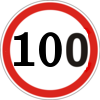

In [ ]:
metl = list(data_dir.rglob('Meta/*'))
PIL.Image.open(str(random.choice(metl)))

In [ ]:
list(data_dir.rglob('Test/*'))[:5]

[PosixPath('/content/drive/My Drive/Codebasics/GTSCDS/Test/10824.png'),
 PosixPath('/content/drive/My Drive/Codebasics/GTSCDS/Test/12260.png'),
 PosixPath('/content/drive/My Drive/Codebasics/GTSCDS/Test/11049.png'),
 PosixPath('/content/drive/My Drive/Codebasics/GTSCDS/Test/10380.png'),
 PosixPath('/content/drive/My Drive/Codebasics/GTSCDS/Test/10811.png')]

In [ ]:
print('Number of Test images: {}'.format(len(list(data_dir.rglob('Test/*.png')))))

Number of Test images: 12630


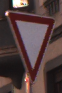

In [ ]:
tesl = list(data_dir.rglob('Test/*'))
PIL.Image.open(str(random.choice(tesl)))

In [ ]:
list(data_dir.glob('Train/*'))[:5]

[PosixPath('/content/drive/My Drive/Codebasics/GTSCDS/Train/1'),
 PosixPath('/content/drive/My Drive/Codebasics/GTSCDS/Train/11'),
 PosixPath('/content/drive/My Drive/Codebasics/GTSCDS/Train/10'),
 PosixPath('/content/drive/My Drive/Codebasics/GTSCDS/Train/12'),
 PosixPath('/content/drive/My Drive/Codebasics/GTSCDS/Train/13')]

In [ ]:
len(list(data_dir.glob('Train/*')))

43

In [ ]:
tl = list(data_dir.glob('Train/*'))
tdict = {}
for i in tl:
  tdict[i.name] = len(list(i.glob('*.png')))

In [ ]:
tdict

{'1': 2220,
 '11': 1320,
 '10': 2010,
 '12': 2100,
 '13': 2160,
 '15': 630,
 '14': 780,
 '16': 420,
 '17': 1110,
 '18': 1200,
 '19': 210,
 '24': 270,
 '23': 510,
 '25': 1500,
 '20': 360,
 '22': 390,
 '2': 2250,
 '26': 600,
 '21': 330,
 '27': 240,
 '28': 540,
 '33': 689,
 '29': 270,
 '32': 240,
 '3': 1410,
 '30': 450,
 '35': 1200,
 '34': 420,
 '31': 780,
 '36': 390,
 '37': 210,
 '6': 420,
 '41': 240,
 '40': 360,
 '39': 300,
 '38': 2070,
 '4': 1980,
 '5': 1860,
 '42': 240,
 '7': 1440,
 '8': 1410,
 '9': 1470,
 '0': 210}

In [ ]:
print('Number of Train images: {}'.format(sum(tdict.values())))

Number of Train images: 39209


In [ ]:
tral = list(data_dir.glob('Train/*'))

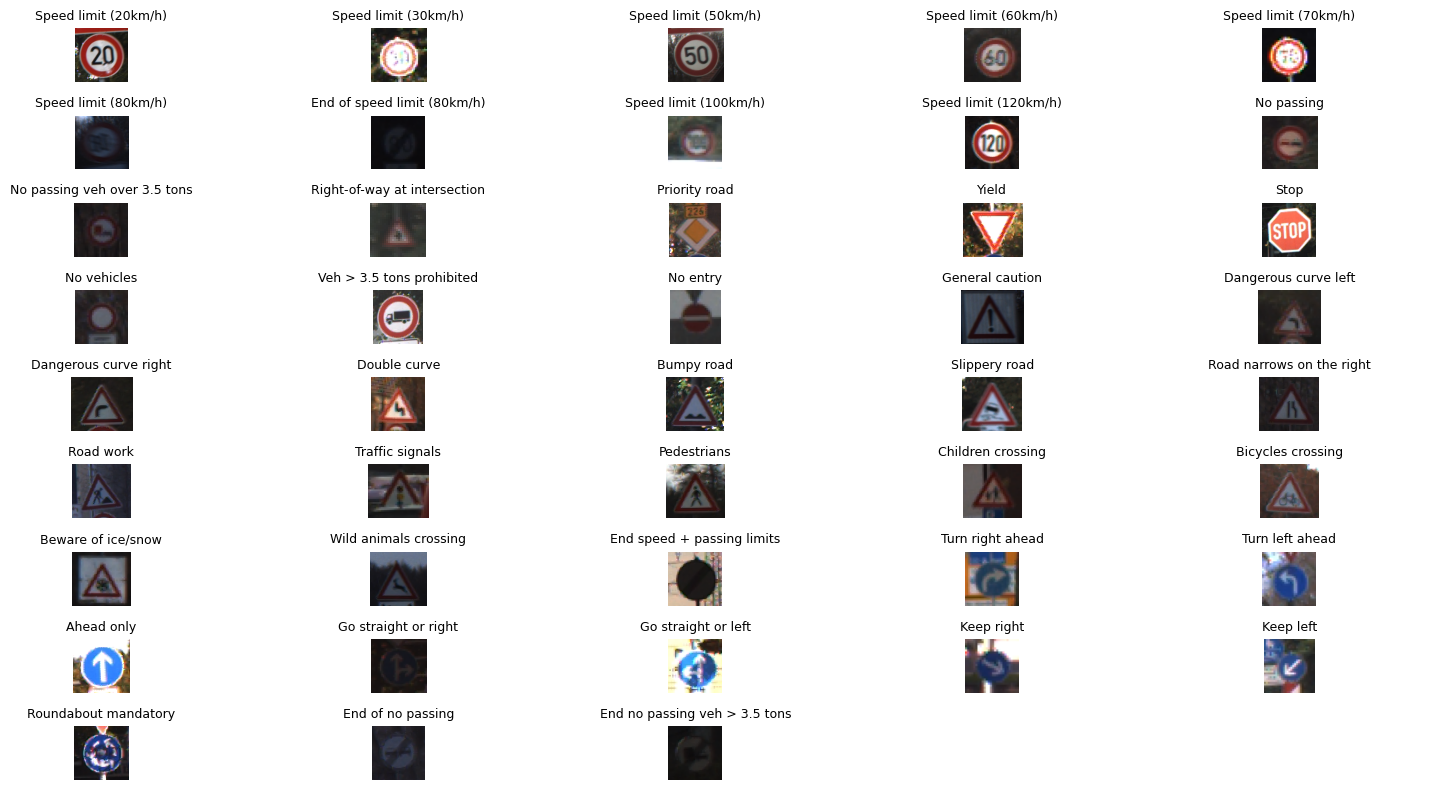

In [ ]:
images_per_row = 5
fig, axes = plt.subplots(
    nrows=(len(tral_sorted) + images_per_row - 1) // images_per_row,
    ncols=images_per_row,
    figsize=(15, 8)
)
axes = axes.flatten()

for idx, folder in enumerate(tral_sorted):
    for image_path in folder.glob('*.png'):
        img = Image.open(image_path)
        axes[idx].imshow(img)
        label = classes.get(int(folder.name), f"Class {folder.name}")
        axes[idx].set_title(label, fontsize=9)
        axes[idx].axis('off')
        break
for ax in axes[len(tral_sorted):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


#Data Augmentation

In [ ]:
max(tdict.values())

2250

In [ ]:
min(tdict.values())

210

In [ ]:
datagen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    brightness_range = [0.8, 1.2],
    horizontal_flip = True,
    fill_mode = 'nearest'
)

datagen2 = ImageDataGenerator(
    rotation_range = 8,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    brightness_range = [0.8, 1.2],
    horizontal_flip = False,
    fill_mode = 'nearest'
)

In [419]:
augmented_dir = pathlib.Path('/content/drive/My Drive/Codebasics/TrafficAugmented/')
tl = list(data_dir.glob('Train/*'))

for i in tl:
  l1 = list(i.glob('*.png'))
  if len(l1) <= max(tdict.values()) :

      folder = augmented_dir / i.name
      limit = max(tdict.values()) - len(l1)
      print(i, limit)

      if int(i.name) not in [19, 20, 33, 34, 36, 37, 38, 39] :
        tl2 = list(folder.glob('*.png'))
        slots = limit - len(tl2)

        while len(tl2) < limit :
          sam = random.choice(l1)
          img_name = sam.name
          img = image.load_img(sam, target_size = (62, 62))
          img_array = image.img_to_array(img)
          img_array = np.expand_dims(img_array, axis = 0)

          aug_iter = datagen.flow(img_array, batch_size = random.randint(1, min(slots, 10)), save_to_dir = str(augmented_dir) + '/' + str(i.name),
                                    save_prefix = 'class' + '|' + str(i.name) + '|' + img_name.split('.')[0], save_format = 'png')
          next(aug_iter)

          tl2 = list(folder.glob('*.png'))

      else :
        tl2 = list(folder.glob('*.png'))
        slots = limit - len(tl2)

        while len(tl2) < limit :
          sam = random.choice(l1)
          img_name = sam.name
          img = image.load_img(sam, target_size = (62, 62))
          img_array = image.img_to_array(img)
          img_array = np.expand_dims(img_array, axis = 0)

          aug_iter = datagen2.flow(img_array, batch_size = random.randint(1, min(slots, 10)), save_to_dir = str(augmented_dir) + '/' + str(i.name),
                                    save_prefix = 'class' + '|' + str(i.name) + '|' + img_name.split('.')[0], save_format = 'png')
          next(aug_iter)

          tl2 = list(folder.glob('*.png'))

/content/drive/My Drive/Codebasics/GTSCDS/Train/1 30
nootnoot
/content/drive/My Drive/Codebasics/GTSCDS/Train/11 930
nootnoot
/content/drive/My Drive/Codebasics/GTSCDS/Train/10 240
nootnoot
/content/drive/My Drive/Codebasics/GTSCDS/Train/12 150
nootnoot
/content/drive/My Drive/Codebasics/GTSCDS/Train/13 90
nootnoot
/content/drive/My Drive/Codebasics/GTSCDS/Train/15 1620
nootnoot
/content/drive/My Drive/Codebasics/GTSCDS/Train/14 1470
nootnoot
/content/drive/My Drive/Codebasics/GTSCDS/Train/16 1830
nootnoot
/content/drive/My Drive/Codebasics/GTSCDS/Train/17 1140
nootnoot
/content/drive/My Drive/Codebasics/GTSCDS/Train/18 1050
nootnoot
/content/drive/My Drive/Codebasics/GTSCDS/Train/19 2040
/content/drive/My Drive/Codebasics/GTSCDS/Train/24 1980
nootnoot
/content/drive/My Drive/Codebasics/GTSCDS/Train/23 1740
nootnoot
/content/drive/My Drive/Codebasics/GTSCDS/Train/25 750
nootnoot
/content/drive/My Drive/Codebasics/GTSCDS/Train/20 1890
/content/drive/My Drive/Codebasics/GTSCDS/Train/22 1

In [418]:
#to clear files from directory
# import pathlib
# import os

# folder_path = pathlib.Path('/content/drive/My Drive/Codebasics/TrafficAugmented/19')

# files = folder_path.glob('*.png')

# for file in files:
#     try:
#         os.remove(file)
#         print(f"Deleted: {file}")
#     except Exception as e:
#         print(f"Error deleting {file}: {e}")


In [420]:
print('Total number of images: {}'.format(len(list(augmented_dir.rglob('*/*.png')))))

Total number of images: 57541


In [422]:
list(augmented_dir.rglob('*/*.png'))[:5]

[PosixPath('/content/drive/My Drive/Codebasics/TrafficAugmented/1/class|1|00001_00017_00029_0_1059.png'),
 PosixPath('/content/drive/My Drive/Codebasics/TrafficAugmented/1/class|1|00001_00023_00002_0_2254.png'),
 PosixPath('/content/drive/My Drive/Codebasics/TrafficAugmented/1/class|1|00001_00046_00005_0_4659.png'),
 PosixPath('/content/drive/My Drive/Codebasics/TrafficAugmented/1/class|1|00001_00014_00015_0_1113.png'),
 PosixPath('/content/drive/My Drive/Codebasics/TrafficAugmented/1/class|1|00001_00024_00029_0_6106.png')]

In [425]:
tl = list(data_dir.glob('Train/*'))
tdict = {}
for i in tl:
  tdict[i.name] = list(i.glob('*.png'))

In [434]:
al = list(augmented_dir.glob('*/*.png'))

for i in al:
    parts = i.name.split('|')
    if len(parts) > 1:
        key = parts[1]
        if key in tdict:
            tdict[key].append(i)

In [438]:
len(tdict['1'])

2250

In [441]:
px.bar(x = tdict.keys(), y = [len(v) for v in tdict.values()],
       width = 800, height = 500)